In [1]:
import os, importlib, sys, time

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import scipy.linalg as la
import scipy.stats as stats

In [4]:
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [26]:
save_dir = "result_covidcast_adj_2_iv_5"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [5]:
data = pd.read_feather('data/CovidCastStateAdj_2.feather').iloc[:,:-1]

In [6]:
GPi = np.load('data/GPi.npz')

In [7]:
data

,geo_value,time_value,deaths,completely_home_prop,median_home_dwell_time,full_time_work_prop,part_time_work_prop
0,al,2020-01-22,0.000000,0.183999,655.805922,0.086965,0.151171
1,al,2020-01-23,0.000000,0.171479,636.370230,0.103856,0.161668
2,al,2020-01-24,0.000000,0.169182,596.711830,0.104405,0.174012
3,al,2020-01-25,0.000000,0.172661,687.538565,0.083919,0.149298
4,al,2020-01-26,0.000000,0.193669,699.710495,0.087651,0.152943
...,...,...,...,...,...,...,...
9066,wv,2020-07-28,0.672611,0.273833,646.344539,0.039517,0.062896
9067,wv,2020-07-29,1.642459,0.270546,637.137487,0.042846,0.068807
9068,wv,2020-07-30,1.000000,0.266332,606.638365,0.051520,0.079922
9069,wv,2020-07-31,4.000000,0.246038,599.132159,0.041380,0.067567


# 2. EDA

In [8]:
iv = [5]
name_of_interventions = np.array(data.columns)[iv]

In [9]:
name_of_interventions

array(['full_time_work_prop'], dtype=object)

In [10]:
regions = np.array(data['geo_value'].unique())
# regions = regions[~np.isin(regions, ['as','gu','mp','vi'])]

In [11]:
regions, len(regions)

(array(['al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'ia',
        'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn',
        'mo', 'ms', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh',
        'ok', 'or', 'pa', 'pr', 'ri', 'sc', 'tn', 'tx', 'ut', 'va', 'vt',
        'wa', 'wi', 'wv'], dtype=object),
 47)

In [12]:
d = len(iv)+1

In [13]:
Ys_raw = [np.array(data[data.geo_value == r].deaths) for r in regions]
As_raw = [np.array(data[data.geo_value == r].iloc[:,iv]) for r in regions]

In [25]:
regions_of_interest = regions[[np.max(Y_raw) > 20 for Y_raw in Ys_raw]]

In [14]:
# Ys_raw = np.where(
#     np.isnan(Ys_raw),
#     (np.roll(Ys_raw, 1, 1) + np.roll(Ys_raw, -1, 1))/2,
#     Ys_raw)

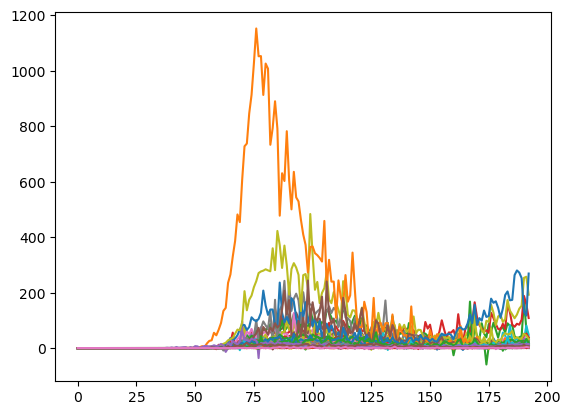

In [15]:
for Y_raw, r in zip(Ys_raw, regions):
    plt.plot(Y_raw, label=r)
# plt.legend()
plt.show()

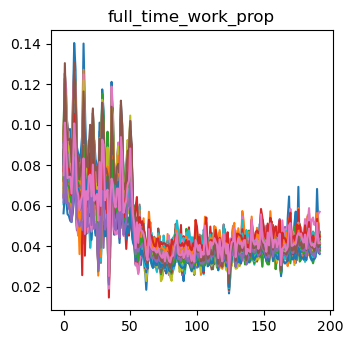

In [16]:
plt.figure(figsize=(8,8))
for i, noi in enumerate(name_of_interventions):
    plt.subplot(2,2,i+1)
    plt.title(noi); # plt.xlabel('days')
    for A_raw, r in zip(As_raw, regions):
        plt.plot(A_raw[:,i], label=r)
# plt.legend()
plt.show()

In [17]:
T0 = 20
alpha = 1
K = 6.5

# 3. EM algorithm

In [18]:
def NBLL(y, m, r):
    if np.isnan(y):
        return 0
    else:
        y = int(y)
        return (np.sum(np.log(1+(r-1)/(np.arange(y)+1))) 
                + r * np.log(r/(r+m)) 
                + y * np.log(m/(r+m)))

In [19]:
def dNBLLdr(y, m, r):
    if np.isnan(y):
        return 0
    else:
        y = int(y)
        return (np.sum(1/(np.arange(y)+r)) + np.log(r/(r+m)) + (m-y)/(r+m))

In [20]:
def d2NBLLdr2(y, m, r):
    if np.isnan(y):
        return 0
    else:
        y = int(y)
        return (-np.sum(1/(np.arange(y)+r)**2) + 1/r + 1/(r+m) - (m-y)/(r+m)**2)

In [21]:
def fit(obs, rinit, minit_0, binit,
        n_iter=3000, history=False, verbose=False, step_size=0.1):
    
    rhat = rinit
    mhat_0 = minit_0
    bhat= np.array(binit)
    ss = np.inf
        
    if history:
        rhs = np.zeros(n_iter)
        mhs_0 = np.zeros(n_iter)
        bhs = np.zeros([n_iter, d])
        lls = np.zeros(n_iter)
        
    Rhat = np.zeros(T+T0)
    d1Rh = np.zeros([d, T+T0])
    d2Rh = np.zeros([d, d, T+T0])
    
    for t in np.arange(T+T0):
        o = np.exp(- bhat @ A[t])
        p = 1 / (1 + o)
        q = o / (1 + o)

        Rhat[t] = K * p
        d1Rh[:,t] = K * p * q * A[t]
        d2Rh[:,:,t] = K * p * q * (q - p) * (A[t,:,None] * A[t])

    Pi = alpha * np.concatenate([[0],pi])[np.maximum(0, T0 + np.arange(T)[:,None] - np.arange(T+T0))]
    G = Rhat[:,None] * np.concatenate([[0],g])[np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
    inv_ImG = la.inv(np.eye(T+T0)-G)
    Pi_inv_ImG = Pi @ inv_ImG
    
    EY = mhat_0 * Pi_inv_ImG[:,0]
    ll = np.sum([NBLL(y, m, rhat) for y, m in zip(obs, EY)])
    
    if verbose:
        print("Before EM, ll: %f"%ll)
    
    for i in np.arange(n_iter):
        start_iter = time.time()

        # derivatives
        d1G = d1Rh[:,:,None] * np.concatenate([[0],g])[
                np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
        d2G = d2Rh[...,None] * np.concatenate([[0],g])[
                np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
        
        d1EY = mhat_0 * (Pi_inv_ImG @ (d1G @ inv_ImG[:,:1]))[...,0]
        d2EY = mhat_0 * (Pi_inv_ImG @ (
            d1G[:,None] @ inv_ImG @ d1G @ inv_ImG[:,:1]
            + d1G @ inv_ImG @ d1G[:,None] @ inv_ImG[:,:1]
            + d2G @ inv_ImG[:,:1]))[...,0]
        
        # first derivative
        dldEY = obs/EY - (rhat+obs)/(rhat+EY)
        
        dldr = np.sum([dNBLLdr(y, m, rhat) for y, m in zip(obs, EY)])
        dldm = np.sum(dldEY * Pi_inv_ImG[:,0])
        dldb = np.sum(dldEY * d1EY, 1)

        dldth = np.concatenate([[dldr, dldm], dldb])
        
        # second deivative
        d2ldEY2 = - obs/EY**2 + (rhat+obs)/(rhat+EY)**2
        d2ldrdEY = - 1/(rhat+EY) + (rhat+obs)/(rhat+EY)**2

        d2ldr2 = np.sum([d2NBLLdr2(y, m, rhat) for y, m in zip(obs, EY)])
        d2ldm2 = np.sum(d2ldEY2 * Pi_inv_ImG[:,0]**2)
        d2ldb2 = np.sum(d2ldEY2 * d1EY * d1EY[:,None,:], 2) \
               + np.sum(dldEY * d2EY, 2)

        d2ldrdm = np.sum(d2ldrdEY * Pi_inv_ImG[:,0])
        d2ldrdb = np.sum(d2ldrdEY * d1EY, 1)
        d2ldmdb = np.sum(d2ldEY2 * Pi_inv_ImG[:,0] * d1EY, 1) \
                + np.sum(dldEY * (Pi_inv_ImG @ (d1G @ inv_ImG[:,:1]))[...,0], 1)
        
        d2ldrm2 = np.array([[d2ldr2, d2ldrdm],
                            [d2ldrdm, d2ldm2]])
        d2ldrmdb = np.stack([d2ldrdb, 
                             d2ldmdb])
        
        d2ldth2 = np.block([[d2ldrm2, d2ldrmdb],
                            [d2ldrmdb.T, d2ldb2]])
        
        # Newton's method
        u, v = la.eig(-d2ldth2)
        # dth = np.real(((v/u) @ v.T) @ dldth)
        dth = np.real(((v/np.maximum(u,np.max(u)/10000)) @ v.T) @ dldth)
        ss = np.min([1, 1/np.sqrt(np.sum(dth**2))])
        
        rhat = np.abs(rhat + ss * dth[0])
        mhat_0 = mhat_0 + ss * dth[1]
        bhat = bhat + ss * dth[2:]
        
        for t in np.arange(T+T0):
            o = np.exp(- bhat @ A[t])
            p = 1 / (1 + o)
            q = o / (1 + o)

            Rhat[t] = K * p
            d1Rh[:,t] = K * p * q * A[t]
            d2Rh[:,:,t] = K * p * q * (q - p) * (A[t,:,None] * A[t])

        Pi = alpha * np.concatenate([[0],pi])[np.maximum(0, T0 + np.arange(T)[:,None] - np.arange(T+T0))]
        G = Rhat[:,None] * np.concatenate([[0],g])[np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
        inv_ImG = la.inv(np.eye(T+T0)-G)
        Pi_inv_ImG = Pi @ inv_ImG
    
        EY = mhat_0 * Pi_inv_ImG[:,0]
        ll = np.sum([NBLL(y, m, rhat) for y, m in zip(obs, EY)])
    
        if history:
            rhs[i] = rhat
            mhs_0[i] = mhat_0
            bhs[i] = bhat
            lls[i] = ll
        
        if verbose:
            print("%d-th iteration finished, ll: %f, lapse: %.3fsec."
                  %(i+1, ll, time.time()-start_iter))
            
    if history:
        return rhs, mhs_0, bhs
    else:
        return rhat, mhat_0, bhat

# 4. estimate + inference

In [22]:
rinit = 2.5
minit_0 = 30
binit = np.zeros(d)

In [24]:
%%notify
for i, (r, Y_raw, A_raw) \
in enumerate(zip(regions, Ys_raw, As_raw)):
    if os.path.isfile('%s/result_%s.npz'%(save_dir,r)):
        continue
        
    start_region = time.time()
    sys.__stdout__.write("Program at %s started \n"%r)
    sys.__stdout__.flush()  
    
    # data
    Y_raw = np.maximum(np.round(Y_raw),0).astype(int)
    POI = np.maximum(np.sum(np.nancumsum(Y_raw)<10),20)
    Y = np.maximum(Y_raw[POI:], 0)
    T = Y.shape[0]
    
    A = np.zeros([T+T0, d])
    A[:,0] = np.full(T+T0, 1)
    A[:,1:] = A_raw[POI-T0:]/np.max(A_raw, 0)
    
    
    # g
    g = np.zeros(T+T0)
    g[:np.minimum(T+T0,len(GPi['g']))] \
    = GPi['g'][:np.minimum(T+T0,len(GPi['g']))]
    
    # pi
    pi = np.zeros(T+T0)
    pi[:np.minimum(T+T0,len(GPi['pi']))] \
    = GPi['pi'][:np.minimum(T+T0,len(GPi['pi']))]
    
    # fit
    rhs, mhs_0, bhs =\
    fit(Y, rinit, minit_0, binit, 
        history=True, verbose=False, n_iter=10000, step_size=1)
    
    sys.__stdout__.write("Estimation at %s finished, lapse: %f sec. \n"
                     %(r, time.time() - start_region))
    sys.__stdout__.flush()  
    
    # collect MLEs
    rmle = rhs[-1]
    mmle_0 = mhs_0[-1]
    bmle = bhs[-1]
    
    Rmle = np.zeros(T+T0)
    d1Rm = np.zeros([d, T+T0])
    d2Rm = np.zeros([d, d, T+T0])
    for t in np.arange(T+T0):
        o = np.exp(- bmle @ A[t])
        p = 1 / (1 + o)
        q = o / (1 + o)

        Rmle[t] = K * p
        d1Rm[:,t] = K * p * q * A[t]
        d2Rm[:,:,t] = K * p * q * (q - p) * (A[t,:,None] * A[t])
    
    # Wald's confidence region
    Pi = alpha * np.concatenate([[0],pi])[
        np.maximum(0, T0 + np.arange(T)[:,None] - np.arange(T+T0))]
    G = Rmle[:,None] * np.concatenate([[0],g])[
        np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
    d1G = d1Rm[:,:,None] * np.concatenate([[0],g])[
        np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
    d2G = d2Rm[...,None] * np.concatenate([[0],g])[
        np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
    
    inv_ImG = la.inv(np.eye(T+T0)-G)
    Pi_inv_ImG = Pi @ inv_ImG
    
    EY = mmle_0 * Pi_inv_ImG[:,0]
    d1EY = mmle_0 * (Pi_inv_ImG @ (d1G @ inv_ImG[:,:1]))[...,0]
    d2EY = mmle_0 * (Pi_inv_ImG @ (
        d1G[:,None] @ inv_ImG @ d1G @ inv_ImG[:,:1]
        + d1G @ inv_ImG @ d1G[:,None] @ inv_ImG[:,:1]
        + d2G @ inv_ImG[:,:1]))[...,0]
    
    dldEY = np.where(
        np.isnan(Y), 0,
        Y/EY - (rmle+Y)/(rmle+EY))
    d2ldEY2 = np.where(
        np.isnan(Y), 0,
        - Y/EY**2 + (rmle+Y)/(rmle+EY)**2)
    d2ldrdEY = np.where(
        np.isnan(Y), 0,
        - 1/(rmle+EY) + (rmle+Y)/(rmle+EY)**2)
    
    d2ldr2 = np.sum([d2NBLLdr2(y, m, rmle) for y, m in zip(Y, EY)])
    d2ldm2 = np.sum(d2ldEY2 * Pi_inv_ImG[:,0]**2)
    d2ldb2 = np.sum(d2ldEY2 * d1EY * d1EY[:,None,:], 2) \
           + np.sum(dldEY * d2EY, 2)

    d2ldrdm = np.sum(d2ldrdEY * Pi_inv_ImG[:,0])
    d2ldrdb = np.sum(d2ldrdEY * d1EY, 1)
    d2ldmdb = np.sum(d2ldEY2 * Pi_inv_ImG[:,0] * d1EY, 1) \
            + np.sum(dldEY * (Pi_inv_ImG @ (d1G @ inv_ImG[:,:1]))[...,0], 1)
    
    d2ldrm2 = np.array([[d2ldr2, d2ldrdm],
                        [d2ldrdm, d2ldm2]])
    d2ldrmdb = np.stack([d2ldrdb, 
                         d2ldmdb])
    
    Ihat_dth = - np.block([[d2ldrm2, d2ldrmdb],
                           [d2ldrmdb.T, d2ldb2]])
    
    # Sandwich estimator
    L_HAC = np.floor(4* (T/100)**(2/9))
    w_HAC = np.maximum(1 - np.abs(np.arange(T)[:,None] - np.arange(T))/L_HAC, 0)
    
    dltdr = np.array([dNBLLdr(y, m, rmle) for y, m in zip(Y, EY)])
    dltdm = dldEY * Pi_inv_ImG[:,0]
    dltdb = dldEY * d1EY
    
    dltdth = np.concatenate([np.array([dltdr, dltdm]), dltdb], 0)
    VEdl = dltdth @ w_HAC @ dltdth.T
    Ihat_sdw = Ihat_dth @ la.inv(VEdl) @ Ihat_dth
    
    sys.__stdout__.write("Inference at %s finished, lapse: %f sec. \n"
                     %(r, time.time() - start_region))
    sys.__stdout__.flush() 
    
    %notify -m "Inference at a region finished."
    
    # save results
    np.savez('%s/result_%s.npz'%(save_dir,r),
             T = T, Y = Y, A = A, g = g, pi = pi, 
             rhs = rhs, mhs_0 = mhs_0, bhs = bhs,
             rmle = rmle, mmle_0 = mmle_0, bmle = bmle, Rmle = Rmle,
             EY = EY, Ihat_dth = Ihat_dth, Ihat_sdw = Ihat_sdw)

Program at al started 
Estimation at al finished, lapse: 73.459235 sec. 
Inference at al finished, lapse: 73.467946 sec. 


<IPython.core.display.Javascript object>

Program at ar started 
Estimation at ar finished, lapse: 71.485807 sec. 
Inference at ar finished, lapse: 71.493799 sec. 


<IPython.core.display.Javascript object>

Program at az started 
Estimation at az finished, lapse: 86.820393 sec. 
Inference at az finished, lapse: 86.829421 sec. 


<IPython.core.display.Javascript object>

Program at ca started 
Estimation at ca finished, lapse: 84.071600 sec. 
Inference at ca finished, lapse: 84.081269 sec. 


<IPython.core.display.Javascript object>

Program at co started 
Estimation at co finished, lapse: 90.485362 sec. 
Inference at co finished, lapse: 90.495149 sec. 


<IPython.core.display.Javascript object>

Program at ct started 
Estimation at ct finished, lapse: 83.868540 sec. 
Inference at ct finished, lapse: 83.878284 sec. 


<IPython.core.display.Javascript object>

Program at dc started 
Estimation at dc finished, lapse: 70.413732 sec. 
Inference at dc finished, lapse: 70.419836 sec. 


<IPython.core.display.Javascript object>

Program at de started 
Estimation at de finished, lapse: 77.401727 sec. 
Inference at de finished, lapse: 77.409951 sec. 


<IPython.core.display.Javascript object>

Program at fl started 
Estimation at fl finished, lapse: 89.441696 sec. 
Inference at fl finished, lapse: 89.455789 sec. 


<IPython.core.display.Javascript object>

Program at ga started 
Estimation at ga finished, lapse: 86.554332 sec. 
Inference at ga finished, lapse: 86.566065 sec. 


<IPython.core.display.Javascript object>

Program at ia started 
Estimation at ia finished, lapse: 80.304687 sec. 
Inference at ia finished, lapse: 80.313951 sec. 


<IPython.core.display.Javascript object>

Program at id started 
Estimation at id finished, lapse: 76.306431 sec. 
Inference at id finished, lapse: 76.315363 sec. 


<IPython.core.display.Javascript object>

Program at il started 
Estimation at il finished, lapse: 86.332369 sec. 
Inference at il finished, lapse: 86.342381 sec. 


<IPython.core.display.Javascript object>

Program at in started 
Estimation at in finished, lapse: 107.952987 sec. 
Inference at in finished, lapse: 107.968566 sec. 


<IPython.core.display.Javascript object>

Program at ks started 
Estimation at ks finished, lapse: 103.400706 sec. 
Inference at ks finished, lapse: 103.409512 sec. 


<IPython.core.display.Javascript object>

Program at ky started 
Estimation at ky finished, lapse: 99.132820 sec. 
Inference at ky finished, lapse: 99.142190 sec. 


<IPython.core.display.Javascript object>

Program at la started 
Estimation at la finished, lapse: 105.134877 sec. 
Inference at la finished, lapse: 105.143983 sec. 


<IPython.core.display.Javascript object>

Program at ma started 
Estimation at ma finished, lapse: 104.924867 sec. 
Inference at ma finished, lapse: 104.934326 sec. 


<IPython.core.display.Javascript object>

Program at md started 
Estimation at md finished, lapse: 96.355048 sec. 
Inference at md finished, lapse: 96.364613 sec. 


<IPython.core.display.Javascript object>

Program at me started 
Estimation at me finished, lapse: 85.628379 sec. 
Inference at me finished, lapse: 85.633680 sec. 


<IPython.core.display.Javascript object>

Program at mi started 
Estimation at mi finished, lapse: 105.641800 sec. 
Inference at mi finished, lapse: 105.653423 sec. 


<IPython.core.display.Javascript object>

Program at mn started 
Estimation at mn finished, lapse: 94.085551 sec. 
Inference at mn finished, lapse: 94.091077 sec. 


<IPython.core.display.Javascript object>

Program at mo started 
Estimation at mo finished, lapse: 99.127752 sec. 
Inference at mo finished, lapse: 99.139244 sec. 


<IPython.core.display.Javascript object>

Program at ms started 
Estimation at ms finished, lapse: 96.390735 sec. 
Inference at ms finished, lapse: 96.401292 sec. 


<IPython.core.display.Javascript object>

Program at nc started 
Estimation at nc finished, lapse: 91.975295 sec. 
Inference at nc finished, lapse: 91.981370 sec. 


<IPython.core.display.Javascript object>

Program at nd started 
Estimation at nd finished, lapse: 80.311573 sec. 
Inference at nd finished, lapse: 80.320006 sec. 


<IPython.core.display.Javascript object>

Program at ne started 
Estimation at ne finished, lapse: 89.097496 sec. 
Inference at ne finished, lapse: 89.113636 sec. 


<IPython.core.display.Javascript object>

Program at nh started 
Estimation at nh finished, lapse: 84.631382 sec. 
Inference at nh finished, lapse: 84.641203 sec. 


<IPython.core.display.Javascript object>

Program at nj started 
Estimation at nj finished, lapse: 109.700158 sec. 
Inference at nj finished, lapse: 109.714504 sec. 


<IPython.core.display.Javascript object>

Program at nm started 
Estimation at nm finished, lapse: 94.117386 sec. 
Inference at nm finished, lapse: 94.124628 sec. 


<IPython.core.display.Javascript object>

Program at nv started 
Estimation at nv finished, lapse: 98.841033 sec. 
Inference at nv finished, lapse: 98.853971 sec. 


<IPython.core.display.Javascript object>

Program at ny started 
Estimation at ny finished, lapse: 116.875808 sec. 
Inference at ny finished, lapse: 116.890085 sec. 


<IPython.core.display.Javascript object>

Program at oh started 
Estimation at oh finished, lapse: 113.667396 sec. 
Inference at oh finished, lapse: 113.677529 sec. 


<IPython.core.display.Javascript object>

Program at ok started 
Estimation at ok finished, lapse: 89.783665 sec. 
Inference at ok finished, lapse: 89.795639 sec. 


<IPython.core.display.Javascript object>

Program at or started 
Estimation at or finished, lapse: 93.272764 sec. 
Inference at or finished, lapse: 93.282458 sec. 


<IPython.core.display.Javascript object>

Program at pa started 
Estimation at pa finished, lapse: 103.162035 sec. 
Inference at pa finished, lapse: 103.176518 sec. 


<IPython.core.display.Javascript object>

Program at pr started 
Estimation at pr finished, lapse: 90.012893 sec. 
Inference at pr finished, lapse: 90.023537 sec. 


<IPython.core.display.Javascript object>

Program at ri started 
Estimation at ri finished, lapse: 89.207710 sec. 
Inference at ri finished, lapse: 89.216665 sec. 


<IPython.core.display.Javascript object>

Program at sc started 
Estimation at sc finished, lapse: 99.379819 sec. 
Inference at sc finished, lapse: 99.387586 sec. 


<IPython.core.display.Javascript object>

Program at tn started 
Estimation at tn finished, lapse: 112.850600 sec. 
Inference at tn finished, lapse: 112.860420 sec. 


<IPython.core.display.Javascript object>

Program at tx started 
Estimation at tx finished, lapse: 134.713347 sec. 
Inference at tx finished, lapse: 134.723173 sec. 


<IPython.core.display.Javascript object>

Program at ut started 
Estimation at ut finished, lapse: 84.296689 sec. 
Inference at ut finished, lapse: 84.304683 sec. 


<IPython.core.display.Javascript object>

Program at va started 
Estimation at va finished, lapse: 102.379924 sec. 
Inference at va finished, lapse: 102.389357 sec. 


<IPython.core.display.Javascript object>

Program at vt started 
Estimation at vt finished, lapse: 80.532970 sec. 
Inference at vt finished, lapse: 80.541895 sec. 


<IPython.core.display.Javascript object>

Program at wa started 
Estimation at wa finished, lapse: 101.113984 sec. 
Inference at wa finished, lapse: 101.126907 sec. 


<IPython.core.display.Javascript object>

Program at wi started 
Estimation at wi finished, lapse: 89.000402 sec. 
Inference at wi finished, lapse: 89.018282 sec. 


<IPython.core.display.Javascript object>

Program at wv started 
Estimation at wv finished, lapse: 66.857047 sec. 
Inference at wv finished, lapse: 66.864345 sec. 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [59]:
# np.savez('%s/result_%s.npz'%(save_dir,r),
#          T = T, Y = Y, A = A, g = g, pi = pi, 
#          rhs = rhs, mhs_0 = mhs_0, bhs = bhs,
#          rmle = rmle, mmle_0 = mmle_0, bmle = bmle, Rmle = Rmle,
#          EY = EY, Ihat_dth = Ihat_dth, Ihat_sdw = Ihat_sdw)

## convergence check

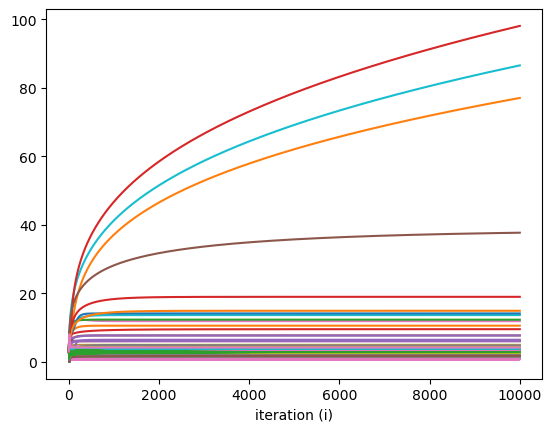

In [27]:
for i, r in enumerate(regions):
    locals().update(np.load('%s/result_%s.npz'%(save_dir,r)))
    plt.plot(rhs, label=r"$\hat{r}_{%s}$"%r)
plt.xlabel("iteration (i)"); # plt.legend()

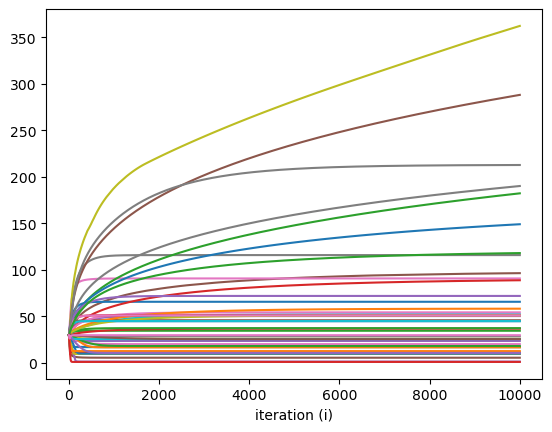

In [28]:
for i, r in enumerate(regions):
    locals().update(np.load('%s/result_%s.npz'%(save_dir,r)))
    plt.plot(mhs_0, label=r"$\hat{\mu}_{%s}$"%r)
plt.xlabel("iteration (i)"); #plt.legend()

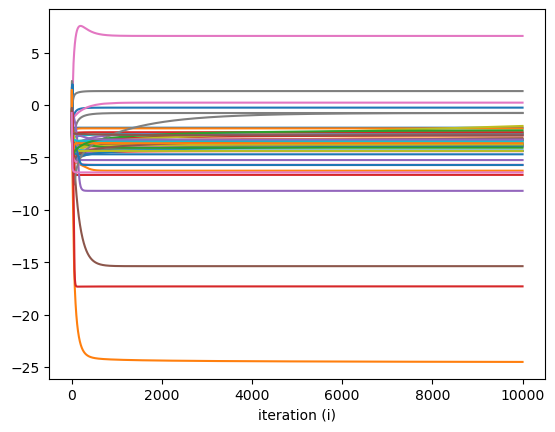

In [29]:
for i, r in enumerate(regions):
    locals().update(np.load('%s/result_%s.npz'%(save_dir,r)))
    plt.plot(bhs[:,0], label=r"$\hat{\beta}^{(0)}_{%s}$"%r)
plt.xlabel("iteration (i)"); # plt.legend()

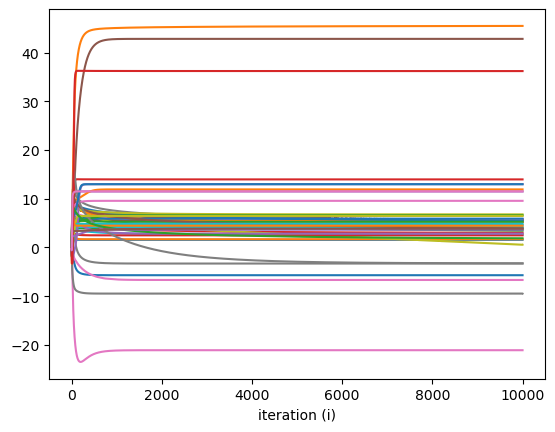

In [30]:
for i, r in enumerate(regions):
    locals().update(np.load('%s/result_%s.npz'%(save_dir,r)))
    plt.plot(bhs[:,1], label=r"$\hat{\beta}^{(1)}_{%s}$"%r)
plt.xlabel("iteration (i)"); # plt.legend()

## plots

In [32]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def confidence_ellipse(mean, cov, ax, n_std=2.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """

    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = mean[0]

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = mean[1]

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

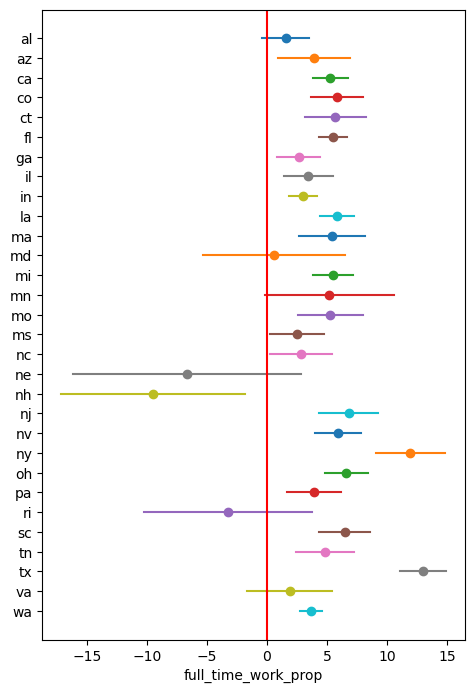

In [34]:
plt.figure(figsize=(12,18))
for k, noi in enumerate(name_of_interventions):
    plt.subplot(2,2,k+1)
    plt.gca().invert_yaxis()
    for i, r in enumerate(regions_of_interest):
        locals().update(np.load('%s/result_%s.npz'%(save_dir,r)))

        se2 = np.diag(np.linalg.pinv(Ihat_dth))[k+3]
        if se2 > 0:
            plt.plot([bmle[k+1]-2*np.sqrt(se2), bmle[k+1]+2*np.sqrt(se2)],
                     [i, i], color='C%d'%i)
        else:
            plt.axhline(y=i, color='C%d'%i)
        plt.scatter(bmle[k+1], i, color='C%d'%i)

    plt.axvline(x=0, color='red')
    plt.yticks(np.arange(len(regions_of_interest)), regions_of_interest)
    plt.xlabel(noi)
plt.show()

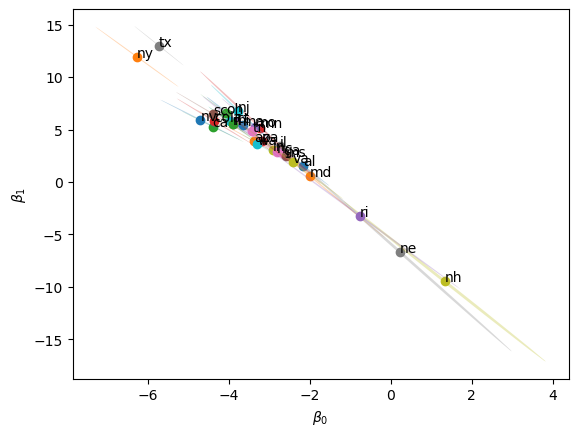

In [36]:
f, ax = plt.subplots(1,1)
for i, r in enumerate(regions_of_interest):
    locals().update(np.load('%s/result_%s.npz'%(save_dir,r)))
    p = ax.scatter(bmle[0], bmle[1], label=r"$\hat{\beta}_{%s}$"%r)
    ax.annotate(r, (bmle[0],bmle[1]))
    confidence_ellipse(bmle, np.linalg.pinv(Ihat_dth)[2:,2:], ax, 
                       facecolor=p.get_facecolor(), alpha=0.3)
plt.xlabel(r"$\beta_0$"); plt.ylabel(r"$\beta_1$"); # plt.legend()

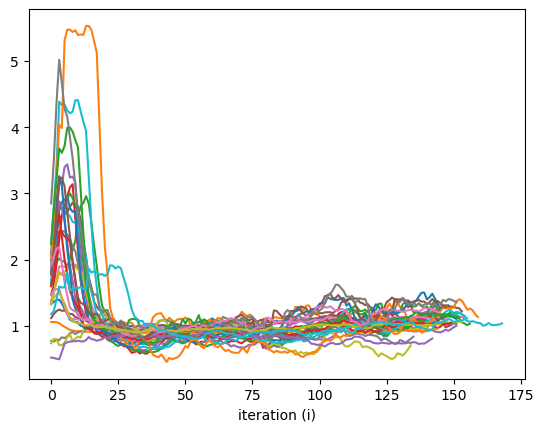

In [37]:
import scipy as sp
for i, r in enumerate(regions_of_interest):
    locals().update(np.load('%s/result_%s.npz'%(save_dir,r)))
    plt.plot(np.exp(sp.signal.convolve(
        np.log(Rmle), np.full(7,1/7), mode='same')),
             label=r"$\hat{R}_{%s}$"%r)
plt.xlabel("iteration (i)"); # plt.legend()

# 5. EBCI

In [38]:
import rpy2.robjects as ro
from rpy2.robjects import rl
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

In [39]:
import rpy2.ipython.html
rpy2.ipython.html.init_printing()

In [40]:
from rpy2.robjects.packages import importr
from rpy2.robjects.lib.dplyr import DataFrame
ebci = importr('ebci')
base = importr('base')

In [42]:
results_binom=[]
for i, r in enumerate(regions_of_interest):
    locals().update(np.load('%s/result_%s.npz'%(save_dir,r)))
    if np.any(np.diag(np.linalg.pinv(Ihat_dth))[2:] < 0) or np.any(np.diag(np.linalg.pinv(Ihat_sdw))[2:] < 0):
        continue
    se = np.sqrt(np.diag(np.linalg.pinv(Ihat_dth))[2:])
    sdw = np.sqrt(np.diag(np.linalg.pinv(Ihat_sdw))[2:])
    results_binom.append(
       {'region':r, 
        'beta_1':bmle[1], 
        'se_1':se[1], 
        'sdw_1':sdw[1]}) 

results_binom=pd.DataFrame(results_binom)
regions_binom=np.array(results_binom.region)

In [49]:
# results.to_csv('results_nbinom.csv', index=False)

In [43]:
with localconverter(ro.default_converter + pandas2ri.converter):
    results_ebci = [ro.conversion.rpy2py(
        ebci.ebci(rl('beta_%d ~ 1'%i), data=results_binom,
                  alpha=0.05, se=rl('se_%d'%i), weights=rl('1/se_%d^2'%i))
        ['df']) for i in np.arange(1,2)]
    
    results_ebci_sdw = [ro.conversion.rpy2py(
        ebci.ebci(rl('beta_%d ~ 1'%i), data=results_binom,
                  alpha=0.05, se=rl('sdw_%d'%i), weights=rl('1/sdw_%d^2'%i))
        ['df']) for i in np.arange(1,2)]

In [44]:
CIs_ebci = [
    r[['th_eb','len_eb','th_us','len_us']] \
    .assign(upper_eb=lambda df: df.th_eb+df.len_eb,
            lower_eb=lambda df: df.th_eb-df.len_eb,
            upper_us=lambda df: df.th_us+df.len_us,
            lower_us=lambda df: df.th_us-df.len_us)
    for r in results_ebci
]

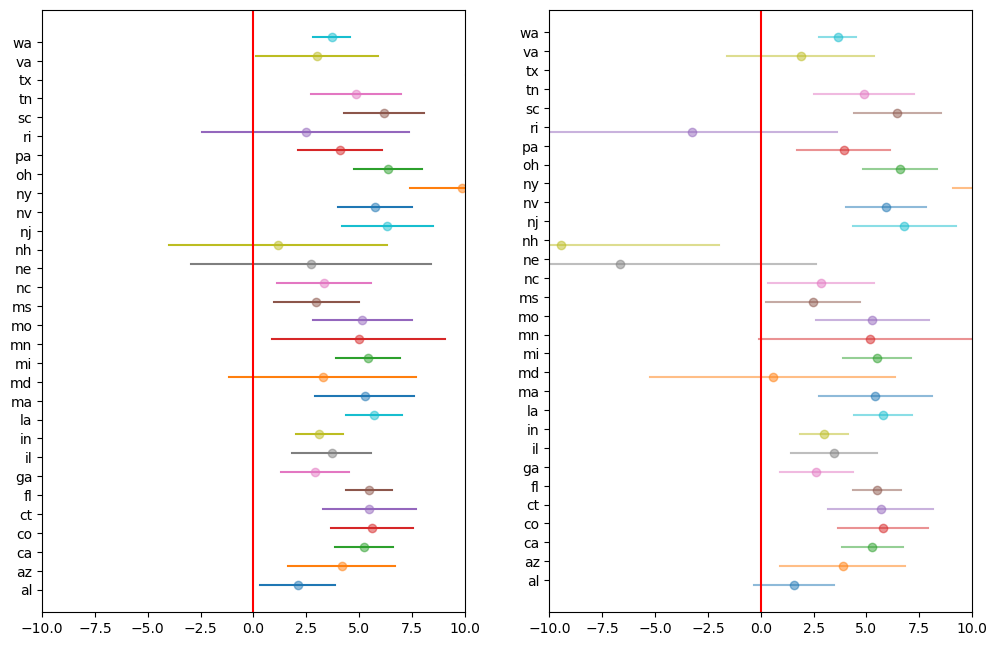

In [45]:
plt.figure(figsize=(12,36))

for k, CI in enumerate(CIs_ebci):
    plt.subplot(4,2,k*2+1)
    for i, r in enumerate(regions_binom):
        plt.plot([CI['lower_eb'][i], CI['upper_eb'][i]],
                 [2*i+1, 2*i+1], color='C%d'%i)
        plt.scatter(CI['th_eb'][i], 2*i+1, color='C%d'%i, alpha=0.5)
    plt.xlim(-10,10)
    plt.axvline(x=0, color='red')
    plt.yticks(2*np.arange(len(regions_binom))+0.5, regions_binom)
    
    plt.subplot(4,2,k*2+2)
    for i, r in enumerate(regions_binom):
        plt.plot([CI['lower_us'][i], CI['upper_us'][i]],
                 [2*i, 2*i], color='C%d'%i, alpha=0.5)
        plt.scatter(CI['th_us'][i], 2*i, color='C%d'%i, alpha=0.5)
    plt.xlim(-10,10)
    plt.axvline(x=0, color='red')
    plt.yticks(2*np.arange(len(regions_binom))+0.5, regions_binom)

plt.show()

In [47]:
CIs_ebci_sdw = [
    r[['th_eb','len_eb','th_us','len_us']] \
    .assign(upper_eb=lambda df: df.th_eb+df.len_eb,
            lower_eb=lambda df: df.th_eb-df.len_eb,
            upper_us=lambda df: df.th_us+df.len_us,
            lower_us=lambda df: df.th_us-df.len_us)
    for r in results_ebci_sdw
]

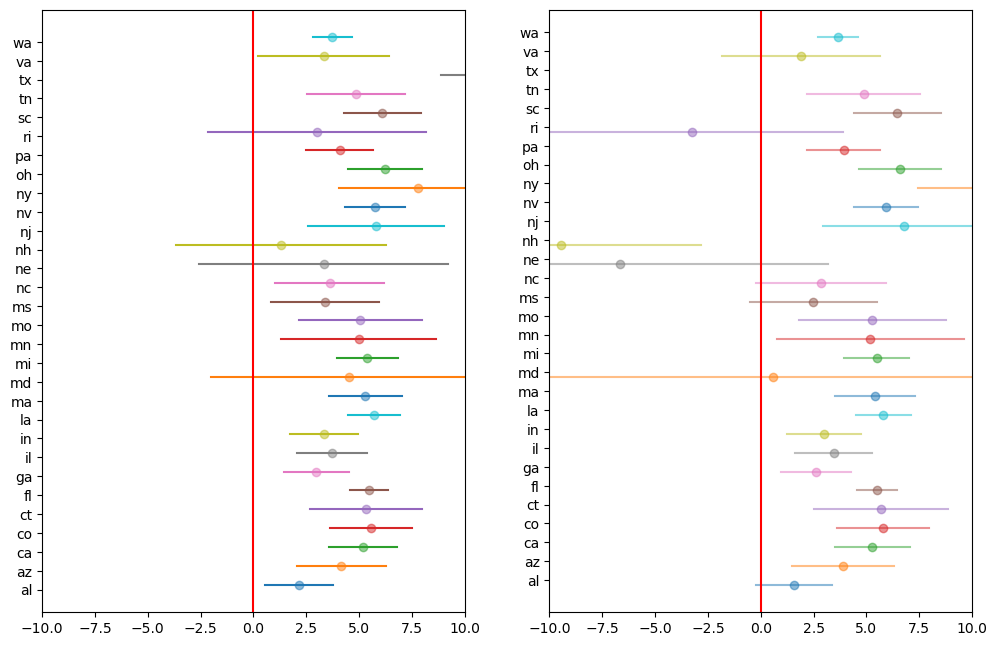

In [48]:
plt.figure(figsize=(12,36))

for k, CI in enumerate(CIs_ebci_sdw):
    plt.subplot(4,2,k*2+1)
    for i, r in enumerate(regions_binom):
        plt.plot([CI['lower_eb'][i], CI['upper_eb'][i]],
                 [2*i+1, 2*i+1], color='C%d'%i)
        plt.scatter(CI['th_eb'][i], 2*i+1, color='C%d'%i, alpha=0.5)
    plt.xlim(-10,10)
    plt.axvline(x=0, color='red')
    plt.yticks(2*np.arange(len(regions_binom))+0.5, regions_binom)

    plt.subplot(4,2,k*2+2)
    for i, r in enumerate(regions_binom):
        plt.plot([CI['lower_us'][i], CI['upper_us'][i]],
                 [2*i, 2*i], color='C%d'%i, alpha=0.5)
        plt.scatter(CI['th_us'][i], 2*i, color='C%d'%i, alpha=0.5)
    plt.xlim(-10,10)
    plt.axvline(x=0, color='red')
    plt.yticks(2*np.arange(len(regions_binom))+0.5, regions_binom)

plt.show()